# KMeans

## 1. Fundamentos de la técnica

KMeans es un algoritmo de **clustering no supervisado** que particiona los datos en $K$ clusters.  
Idea: asignar cada punto al centro (centroide) más cercano y actualizar los centroides hasta converger.  
No "entrena" en sentido supervisado; encuentra grupos en los datos.

## 2. Modelo matemático

KMeans busca minimizar la suma de las distancias al cuadrado dentro de cada cluster (Within-Cluster Sum of Squares — WCSS):

$$
\min_{C, \{\mu_k\}_{k=1}^K} \sum_{k=1}^{K} \sum_{x_i \in C_k} \| x_i - \mu_k \|^2
$$

donde $C_k$ es el conjunto de puntos asignados al cluster $k$ y $mu_k$ es su centroide (media).


## 3. Librerías / clases / funciones

Usaremos:
- `sklearn.cluster.KMeans` — implementación estándar de KMeans.
- `sklearn.preprocessing.StandardScaler` — normalizar features.
- `sklearn.metrics` — `confusion_matrix`, `accuracy_score`, `contingency_matrix`.
- `scipy.optimize.linear_sum_assignment` — para encontrar el mejor mapeo entre clusters y etiquetas reales (Hungarian algorithm).
- `matplotlib.pyplot` y `pandas` — visualización y estadística descriptiva.


In [1]:
# ===========================
# Bloque 1: Importaciones
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix as cm_metric
from sklearn.metrics.cluster import contingency_matrix

from scipy.optimize import linear_sum_assignment

## 4. Pipeline
A continuación: preprocesamiento (estadísticas + scatter), KMeans, función de predicción para un patrón, y evaluación con matriz de confusión y accuracy (usando mapeo cluster→etiqueta).

In [2]:
# ===========================
# Bloque 2: Cargar dataset y preparar
# ===========================
iris = load_iris()
X_full = iris.data     # 4 features
y_full = iris.target   # 3 clases

# Para buena visualización usaremos solo 2 features (sepal length, sepal width)
feature_idx = [0, 1]
X = X_full[:, feature_idx]
y = y_full

feature_names = [iris.feature_names[i] for i in feature_idx]

print("Feature names:", feature_names)
print("X shape:", X.shape, "y shape:", y.shape)

Feature names: ['sepal length (cm)', 'sepal width (cm)']
X shape: (150, 2) y shape: (150,)


Estadísticas descriptivas (features seleccionadas):


,sepal length (cm),sepal width (cm),label
count,150.000000,150.000000,150.000000
mean,5.843333,3.057333,1.000000
std,0.828066,0.435866,0.819232
min,4.300000,2.000000,0.000000
25%,5.100000,2.800000,0.000000
50%,5.800000,3.000000,1.000000
75%,6.400000,3.300000,2.000000
max,7.900000,4.400000,2.000000


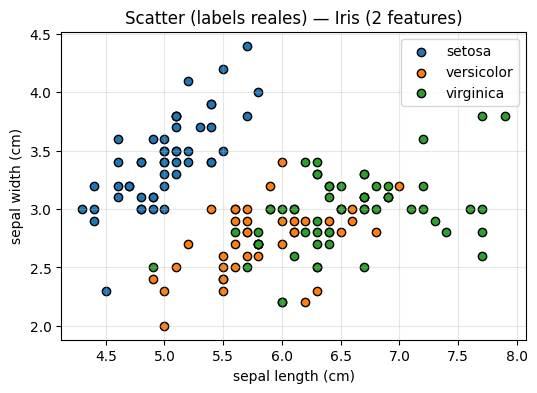

In [3]:
# ===========================
# Bloque 3: Preprocesamiento (estadísticas y scatter)
# ===========================
df = pd.DataFrame(X, columns=feature_names)
df['label'] = y

print("Estadísticas descriptivas (features seleccionadas):")
display(df.describe())

# Scatter plot coloreado por etiqueta real (solo para referencia visual)
plt.figure(figsize=(6,4))
for lab in np.unique(y):
    plt.scatter(df[df['label']==lab].iloc[:,0],
                df[df['label']==lab].iloc[:,1],
                label=iris.target_names[lab],
                edgecolor='k')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Scatter (labels reales) — Iris (2 features)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Normalización**: KMeans funciona mejor si las features están en la misma escala.

In [4]:
# ===========================
# Bloque 4: Normalizar y dividir
# ===========================
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

# Dividimos (opcional para simular evaluación en "test"), aunque KMeans no requiere split para entrenar.
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.3, random_state=42, stratify=y)

print("Tamaños: ", X_train.shape, X_test.shape)

Tamaños:  (105, 2) (45, 2)


In [5]:
# ===========================
# Bloque 5: Entrenar KMeans
# ===========================
# Elegimos K = número de clases reales para comparar (a modo de ejercicio)
K = len(np.unique(y))
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
kmeans.fit(X_train)   # ajusta centroides al conjunto de entrenamiento

print("Centroides (en escala estandarizada):")
print(kmeans.cluster_centers_)


Centroides (en escala estandarizada):
[[ 1.39718094  0.21331567]
 [-0.01788669 -0.91026378]
 [-0.98722965  0.90719449]]


In [6]:
# ===========================
# Bloque 6: Predicción (función para un patrón)
# ===========================
def predecir_patron_kmeans(patron_raw, kmeans_model, scaler, feature_names):
    """
    patron_raw: array-like (sin escalar) con la misma cantidad de features (aquí 2)
    kmeans_model: modelo entrenado
    scaler: StandardScaler usado
    """
    x = np.array(patron_raw).reshape(1, -1)
    x_s = scaler.transform(x)
    cluster = kmeans_model.predict(x_s)[0]
    print("Entrada (raw):", dict(zip(feature_names, x.flatten().tolist())))
    print("Cluster asignado:", int(cluster))
    return int(cluster)

# Ejemplo:
ejemplo_raw = scaler.inverse_transform(X_test[0].reshape(1,-1)).flatten()  # volver a raw para el ejemplo
predecir_patron_kmeans(ejemplo_raw, kmeans, scaler, feature_names)


Entrada (raw): {'sepal length (cm)': 7.3, 'sepal width (cm)': 2.9}
Cluster asignado: 0


0

### Evaluación:
- Como KMeans no da etiquetas reales, para comparar con `y_test` realizamos un **mapeo** de clusters→etiquetas reales usando la **matriz de contingencia** y el **Hungarian algorithm** (linear_sum_assignment) que maximiza la coincidencia.

Matriz de contingencia (filas=etiquetas reales, columnas=clusters):
[[ 0  0 15]
 [ 5  9  1]
 [ 7  8  0]]
Mapping cluster -> label (estimado): {np.int64(2): np.int64(0), np.int64(1): np.int64(1), np.int64(0): np.int64(2)}
Accuracy (test) tras mapear clusters a etiquetas: 68.89%
Matriz de confusión (filas=verdaderas, columnas=predichas):
[[15  0  0]
 [ 1  9  5]
 [ 0  8  7]]


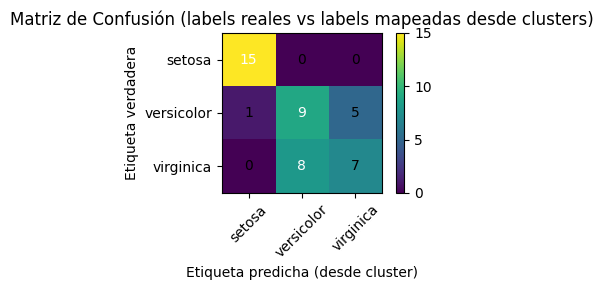

In [7]:
# ===========================
# Bloque 7: Evaluación — mapeo clusters->labels, matriz de confusión y accuracy
# ===========================
# Predecir clusters en X_test
clusters_test = kmeans.predict(X_test)

# Crear matriz de contingencia entre clusters y etiquetas verdaderas
cont = contingency_matrix(y_test, clusters_test)
print("Matriz de contingencia (filas=etiquetas reales, columnas=clusters):")
print(cont)

# Resolver asignación óptima (maximizar coincidencia)
# linear_sum_assignment minimiza costo, así que usamos -cont para maximizar
row_ind, col_ind = linear_sum_assignment(-cont)

# Crear mapping cluster -> label
cluster_to_label = {}
for r, c in zip(row_ind, col_ind):
    cluster_to_label[c] = r

print("Mapping cluster -> label (estimado):", cluster_to_label)

# Mapear predicted clusters a labels estimadas
y_pred_mapped = np.array([cluster_to_label[c] for c in clusters_test])

# Matriz de confusión y accuracy
cm = confusion_matrix(y_test, y_pred_mapped)
acc = accuracy_score(y_test, y_pred_mapped)

print(f"Accuracy (test) tras mapear clusters a etiquetas: {acc*100:.2f}%")
print("Matriz de confusión (filas=verdaderas, columnas=predichas):")
print(cm)

# Visualizar matriz
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title('Matriz de Confusión (labels reales vs labels mapeadas desde clusters)')
plt.colorbar()
plt.xticks(range(K), [iris.target_names[i] for i in range(K)], rotation=45)
plt.yticks(range(K), [iris.target_names[i] for i in range(K)])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha (desde cluster)')
plt.tight_layout()
plt.show()

## 5. Referencias bibliográficas

- MacQueen, J. (1967). *Some methods for classification and analysis of multivariate observations* (introducción de KMeans).  
- Bishop, C. M. (2006). *Pattern Recognition and Machine Learning*. Springer.  
- Scikit-learn: `KMeans` — https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html